In [2]:
%reload_ext autoreload
%autoreload 2

import os, psutil

os.environ['NUMEXPR_MAX_THREADS'] = '20'
os.environ['NUMBA_DEBUGINFO'] = '0'

from alphadia.extraction import processlogger
processlogger.init_logging()
import logging

logger = logging.getLogger()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import neptune.new as neptune

#from alphabase.spectral_library.flat import SpecLibFlat
from alphabase.spectral_library.base import SpecLibBase
#from alphabase.spectral_library.reader import LibraryReaderBase

from alphadia.extraction.data import TimsTOFDIA
from alphadia.extraction.planning import Plan, Workflow
from alphadia.extraction.calibration import RunCalibration
from alphadia.extraction.candidateselection import MS1CentricCandidateSelection
from alphadia.extraction.scoring import fdr_correction, MS2ExtractionWorkflow
import alphadia.extraction.utils as utils
yaml_file = 'config.yaml'

raw_files = ['/Users/georgwallmann/Documents/data/alphadia_benchmarking/raw_data/2023_03_02_MCT_scp_hela/20230103_TIMS05_MCT_SA_HeLa_SM03p7b_Ref10_AID8_02_S4-E9_1_645.d',
             #'/Users/georgwallmann/Documents/data/raw_data/Alpha_dia_benchmarking/diaPASEF_vs_synchroPASEF/20221221_TIMS05_PaSk_SA_HeLa_Evo05_200ng_21min_IM0713_SyP_classical_5bins_S2-A1_1_449.d',
             #'/Users/georgwallmann/Documents/data/raw_data/Alpha_dia_benchmarking/diaPASEF_vs_synchroPASEF/20221221_TIMS05_PaSk_SA_HeLa_Evo05_200ng_21min_IM0713_SyP_classical_5bins_S2-A2_1_453.d',
             #'/Users/georgwallmann/Documents/data/raw_data/Alpha_dia_benchmarking/diaPASEF_vs_synchroPASEF/20221221_TIMS05_PaSk_SA_HeLa_Evo05_200ng_21min_IM0713_SyP_classical_5bins_S2-A3_1_457.d',
             #'/Users/georgwallmann/Documents/data/raw_data/Alpha_dia_benchmarking/diaPASEF_vs_synchroPASEF/20221221_TIMS05_PaSk_SA_HeLa_Evo05_200ng_21min_IM0713_SyP_classical_5bins_S2-A4_1_464.d'

             ]

output_location = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/alphadia_runs'

try:
    neptune_token = os.environ['NEPTUNE_TOKEN']
except KeyError:
    logger.error('NEPTUNE_TOKEN environtment variable not set')


0:00:02.645889  WARNING: WARNING: Temp mmap arrays are written to /var/folders/lc/9594t94d5b5_gn0y04w1jh980000gn/T/temp_mmap_g1jd1_jg. Cleanup of this folder is OS dependant, and might need to be triggered manually! Current space: 1,191,431,565,312
0:00:02.646465  WARNING: WARNING: No Bruker libraries are available for this operating system. Mobility and m/z values need to be estimated. While this estimation often returns acceptable results with errors < 0.02 Th, huge errors (e.g. offsets of 6 Th) have already been observed for some samples!
0:00:02.646691  INFO: 


In [3]:
test_lib = SpecLibBase()
test_lib_location = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/marvin_scp/MSfragger_library_mod_noLossType_d0_d4_d8_shared_eg.hdf'
test_lib.load_hdf(test_lib_location, load_mod_seq=True)

#test_lib.precursor_df = test_lib.precursor_df[test_lib.precursor_df['channel'] == 0]

In [4]:
plan = Plan(raw_files)
plan.from_spec_lib_base(test_lib)
#plan.run(output_location, keep_decoys=True, fdr=1.0)
for dia_data, precursors_flat, fragments_flat in plan.get_run_data():
    break

0:00:06.014995  PROGRESS:       _   _      _         ___ ___   _   
0:00:06.015563  PROGRESS:      /_\ | |_ __| |_  __ _|   \_ _| /_\  
0:00:06.015968  PROGRESS:     / _ \| | '_ \ ' \/ _` | |) | | / _ \ 
0:00:06.016216  PROGRESS:    /_/ \_\_| .__/_||_\__,_|___/___/_/ \_\
0:00:06.016452  PROGRESS:            |_|                            
0:00:06.016689  PROGRESS: 
0:00:06.017102  INFO: loading default config from /Users/georgwallmann/Documents/git/alphadia/alphadia/extraction/../../misc/config/default.yaml
0:00:06.022196  PROGRESS: version: 1.0.1
0:00:06.022436  PROGRESS: hostname: Georgs-MacBook-Pro.local
0:00:06.022634  PROGRESS: date: 2023-03-29 13:32:37
0:00:10.098516  INFO: renaming precursor_columns columns
0:00:10.099593  INFO: renaming fragment_columns columns
0:00:10.100006  INFO: ========= Library Stats =========
0:00:10.100216  INFO: Number of precursors: 275,196
0:00:10.131699  INFO: 	thereof targets:137,601
0:00:10.132142  INFO: 	thereof decoys: 137,595
0:00:10.134024  IN

In [5]:
jit_data = dia_data.jitclass(transpose=True)

In [163]:
from alphadia.extraction import hybridselection

precursors_flat = precursors_flat.sort_values('rt_library')

selection = hybridselection.HybridCandidateSelection(
    jit_data,
    precursors_flat[:2000],
    fragments_flat,
    rt_tolerance=360,
    mz_tolerance=30,
    mobility_tolerance=0.06,
    candidate_count=3,
    thread_count=12,
    debug=True,
    score_grouped=True,
    )
egs = selection()

0:34:38.461074  INFO: Duty cycle consists of 9 frames, 0.96 seconds cycle time
0:34:38.461493  INFO: Duty cycle consists of 928 scans, 0.00065 1/K_0 resolution
0:34:38.461750  INFO: Expected peak length in RT is 10.00 seconds, sigma is 5.21
0:34:38.461982  INFO: Expected peak length in mobility is 0.03 1/K_0, sigma is 23.20
0:34:38.463652  INFO: starting candidate selection
100%|██████████| 10/10 [00:00<00:00, 16.78it/s]


In [164]:
from alphadia.extraction.numba import fragments

In [165]:
from alphadia.extraction.numba import fragments, numeric
from alphadia.extraction.candidateselection import peak_boundaries_symmetric, GaussianFilter
gaussian_filter = GaussianFilter(
    dia_data
)
kernel = gaussian_filter.get_kernel()

0:34:41.939824  INFO: Duty cycle consists of 9 frames, 0.96 seconds cycle time
0:34:41.941366  INFO: Duty cycle consists of 928 scans, 0.00065 1/K_0 resolution
0:34:41.942263  INFO: Expected peak length in RT is 10.00 seconds, sigma is 5.21
0:34:41.942943  INFO: Expected peak length in mobility is 0.03 1/K_0, sigma is 23.20


In [166]:
eg = egs[0]

In [167]:
eg.precursor_mz

array([351.15237, 352.15866, 353.16348, 360.15518, 361.16147, 362.1663 ],
      dtype=float32)

In [168]:
import numba as nb
@nb.njit
def build_features(
    smooth_precursor,
    smooth_fragment,
    precursor_intensity,
    fragment_intensity
):
    
    n_features = 6

    features = np.zeros(
        (
            n_features,
            smooth_precursor.shape[2],
            smooth_fragment.shape[3],
            
        ),
        dtype=np.float32
    )

    precursor_kernel = precursor_intensity.reshape(-1, 1, 1)
    fragment_kernel = fragment_intensity.reshape(-1, 1, 1)

    fragment_binary = smooth_fragment[0] > 2
    #fragment_binary_sum = np.sum(fragment_binary, axis=0)
    fragment_binary_weighted = np.sum(fragment_binary * fragment_kernel, axis=0)

    precursor_binary = smooth_precursor[0] > 2
    #precursor_binary_sum = np.sum(precursor_binary, axis=0)
    precursor_binary_weighted = np.sum(precursor_binary * precursor_kernel, axis=0)

    precursor_dot = np.sum(smooth_precursor[0] * precursor_kernel, axis=0)
    precursor_dot_mean = np.mean(precursor_dot)
    precursor_norm = precursor_dot/(precursor_dot_mean+0.0001)

    fragment_dot = np.sum(smooth_fragment[0] * fragment_kernel, axis=0)
    fragment_dot_mean = np.mean(fragment_dot)
    fragment_norm = fragment_dot/(fragment_dot_mean+0.001)

    fragment_mass_error = np.sum(np.abs(smooth_fragment[1]), axis=0)
    fragment_mass_error_max = np.max(fragment_mass_error)
    fragment_mass_error_norm = 1-(fragment_mass_error/fragment_mass_error_max)

    precursor_mass_error = np.sum(np.abs(smooth_precursor[1]), axis=0)
    precursor_mass_error_max = np.max(precursor_mass_error)
    precursor_mass_error_norm = 1-(precursor_mass_error/precursor_mass_error_max)

    features[0] = fragment_binary_weighted
    features[1] = fragment_norm
    features[2] = fragment_mass_error_norm
    features[3] = precursor_binary_weighted
    features[4] = precursor_norm
    features[5] = precursor_mass_error_norm

    return features




In [169]:
@nb.njit
def join_close_peaks(
    peak_scan_list,
    peak_cycle_list,
    peak_score_list,
    scan_tolerance,
    cycle_tolerance
    ):
    """
    find peaks that are close in scan and cycle and return
    """
    n_peaks = peak_scan_list.shape[0]
    peak_mask = np.ones(n_peaks, dtype=np.bool_)
    for peak_idx in range(n_peaks):
        if not peak_mask[peak_idx]:
            continue
        scan = peak_scan_list[peak_idx]
        cycle = peak_cycle_list[peak_idx]
        score = peak_score_list[peak_idx]
        for other_peak_idx in range(peak_idx+1, n_peaks):
            if not peak_mask[other_peak_idx]:
                continue
            other_scan = peak_scan_list[other_peak_idx]
            other_cycle = peak_cycle_list[other_peak_idx]
            other_score = peak_score_list[other_peak_idx]
            if abs(scan-other_scan) <= scan_tolerance and abs(cycle-other_cycle) <= cycle_tolerance:
                if score > other_score:
                    peak_mask[other_peak_idx] = False
                else:
                    peak_mask[peak_idx] = False
                    break

    return peak_mask

In [170]:
@nb.experimental.jitclass()
class Candidate:

    elution_group_idx: nb.int64
    score_group: nb.int64
    precursor_idx: nb.int64
    rank: nb.int64

    score: nb.float64
    precursor_mz: nb.float64
    features: nb.float32[::1]

    limit_scan: nb.int64[::1]
    limit_cycle: nb.int64[::1]

    center_scan: nb.int64
    center_cycle: nb.int64


    def __init__(
            self,
            elution_group_idx,
            score_group,
            precursor_idx,
            rank,
            score,
            precursor_mz,
            features,
            limit_scan,
            limit_cycle,
            center_scan,
            center_cycle
    ):
        self.elution_group_idx = elution_group_idx
        self.score_group = score_group
        self.precursor_idx = precursor_idx
        self.rank = rank
        self.score = score
        self.precursor_mz = precursor_mz
        self.features = features
        self.limit_scan = limit_scan
        self.limit_cycle = limit_cycle
        self.center_scan = center_scan
        self.center_cycle = center_cycle

candidate_type = Candidate.class_type.instance_type

In [171]:
@nb.njit
def wrap0(
    value,
    limit,
):
    if value < 0:
        return 0
    else:
        return min(value, limit)
    

@nb.njit
def wrap1(
    values,
    limit,
):
    for i in range(values.shape[0]):
        values[i] = wrap0(values[i], limit)
    return values

@nb.njit
def get_mean0(dense, scan, cycle):
    """ create a fixed window around the peak and extract the mean value
    """
    # window size around peak
    w = 4

    # extract mz
    mz_window = dense[
        max(scan-w,0):scan+w,
        max(cycle-w,0):cycle+w
    ].flatten()

    return np.mean(mz_window)

@nb.njit
def get_mean_sparse0(dense, scan, cycle, threshold):
    """ create a fixed window around the peak and extract the mean value
    """
    # window size around peak
    w = 4

    # extract mz
    mz_window = dense[
        max(scan-w,0):scan+w,
        max(cycle-w,0):cycle+w
    ].flatten()

    mask = (mz_window < threshold)
    fraction_nonzero = np.mean(mask.astype('int8'))

    if fraction_nonzero > 0:
        values = np.mean(mz_window[mask])
    else:
        values = threshold

    return values

In [215]:
@nb.njit
def build_candidates(
    dense_precursors,
    dense_fragments,
    scan_limits,
    frame_limits,
    precursor_mz,
    precursor_intensity,
    fragment_mz,
    fragment_intensity,
    eg,
    kernel,
    jit_data,
    candidate_count,
    weights = None,
    mean = None,
    std = None,
    ):

    cycle_length = jit_data.cycle.shape[1]

    candidates = nb.typed.List.empty_list(candidate_type)

    if weights is None:
        feature_weights = np.ones(6)
    else:
        feature_weights = weights
    feature_weights = feature_weights.reshape(-1,1,1)

    smooth_precursor = numeric.fourier_a1(dense_precursors, kernel)
    smooth_fragment = numeric.fourier_a1(dense_fragments, kernel)
    
    n_score_groups = precursor_intensity.shape[0]
    # iterate all score groups
    for score_group in range(n_score_groups):
        
        # create a mask which allows to select only a certain score group
        fragment_mask = fragment_intensity[score_group] > 0
        precursor_mask = precursor_intensity[score_group] > 0

        currrent_dense_precursor = dense_precursors[:,precursor_mask]
        current_smooth_precursor = smooth_precursor[:,precursor_mask]
        current_dense_fragment = dense_fragments[:,fragment_mask]
        current_smooth_fragment = smooth_fragment[:,fragment_mask]

        feature_matrix = build_features(
            current_smooth_precursor,
            current_smooth_fragment,
            precursor_intensity[score_group][precursor_mask],
            fragment_intensity[score_group][fragment_mask],
        ).astype('float32')

        # get mean and std to normalize features
        # if trained, use the mean and std from training
        # otherwise calculate the mean and std from the current data
        if mean is None:
            feature_mean = utils.amean1(feature_matrix)
        else:
            feature_mean = mean
        feature_mean = feature_mean.reshape(-1,1,1)

        if std is None:
            feature_std = utils.astd1(feature_matrix).reshape(-1,1,1)
        else:
            feature_std = std
        feature_std = feature_std.reshape(-1,1,1)

        # make sure that mean, std and weights have the same shape
        if not (feature_std.shape == feature_mean.shape == feature_weights.shape):
            raise ValueError("feature_mean, feature_std and feature_weights must have the same shape")
        

        feature_matrix_norm = feature_weights * (feature_matrix - feature_mean)/feature_std
        score = np.sum(feature_matrix_norm, axis=0)

        peak_scan_list, peak_cycle_list, peak_score_list = utils.find_peaks(
            score, top_n=candidate_count
        )

        print(peak_scan_list, peak_cycle_list, peak_score_list)

        peak_mask = join_close_peaks(peak_scan_list, peak_cycle_list, peak_score_list, 3, 3)
        
        peak_scan_list = peak_scan_list[peak_mask]
        peak_cycle_list = peak_cycle_list[peak_mask]
        peak_score_list = peak_score_list[peak_mask]

        print(peak_scan_list, peak_cycle_list, peak_score_list)

        with nb.objmode():
            plt.imshow(score)
            plt.scatter(peak_cycle_list, peak_scan_list, c='red', s=1)
            plt.show()
        
        for i, (scan_relative, cycle_relative) in enumerate(zip(peak_scan_list, peak_cycle_list)):

            scan_limits_relative, cycle_limits_relative = peak_boundaries_symmetric(
                score, 
                scan_relative, 
                cycle_relative, 
                f_mobility=0.99,
                f_rt=0.99,
                center_fraction=0.05,
                min_size_mobility=10,
                min_size_rt=5,
                max_size_mobility = 40,
                max_size_rt = 30,
            )

            scan_limits_absolute = wrap1(scan_limits_relative + scan_limits[0,0], jit_data.scan_max_index)
            frame_limits_absolute = wrap1(cycle_limits_relative * cycle_length + frame_limits[0,0], jit_data.frame_max_index)

            scan_absolute = wrap0(scan_relative + scan_limits[0,0], jit_data.scan_max_index)
            frame_absolute = wrap0(cycle_relative * cycle_length + frame_limits[0,0], jit_data.frame_max_index)

            features = np.zeros(feature_matrix.shape[0], dtype='float32')
            for j in range(feature_matrix.shape[0]):
                features[j] = get_mean0(feature_matrix[j], scan_relative, cycle_relative)

            mass_error = np.zeros(currrent_dense_precursor.shape[1], dtype='float32')
            for j in range(currrent_dense_precursor.shape[0]):
                mass_error[j] = get_mean_sparse0(currrent_dense_precursor[1,j], scan_relative, cycle_relative, 110)

            # iterate all precursors within this score group
            for j, precursor_score_group in enumerate(eg.precursor_score_group):
                if score_group == precursor_score_group:
  
                    candidates.append(
                        Candidate(
                            eg.elution_group_idx,
                            score_group,
                            eg.precursor_idx[j],
                            i,
                            peak_score_list[i],
                            eg.precursor_mz[j],
                            features,
                            scan_limits_absolute.astype('int64'),
                            frame_limits_absolute.astype('int64'),
                            scan_absolute,
                            frame_absolute
                        )
                    )

                    


    return candidates
        
import matplotlib.patches as patches


In [216]:
print(nb.typeof(eg.elution_group_idx))

int64


[35 16 15  7  6  5  9 24 99 98 10 13 33  7 14] [202 152 153 263 104 105 141  80 288 289  74  73 325  54  94] [30.31824634 18.49464076 18.4362666  16.33174461 15.5936622  15.49705179
 15.44789708 13.06189201 12.07514351 11.95227292 11.46947638 11.39262871
 10.33773871 10.21755122  9.84126934]
[35 16  7  6  9 24 99 10 33  7 14] [202 152 263 104 141  80 288  74 325  54  94] [30.31824634 18.49464076 16.33174461 15.5936622  15.44789708 13.06189201
 12.07514351 11.46947638 10.33773871 10.21755122  9.84126934]


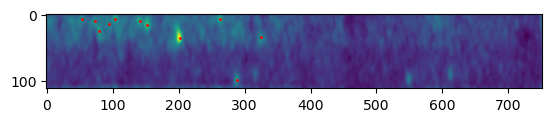

[34 50  9  6  8 39 15  9 14  9  7  7  5 19 12] [325 229  74 142 153 597 122 199  38 124 125 105  27  38  65] [22.90318287 21.14896363 18.18047216 17.84034557 15.0285697  14.00146474
 10.89982922 10.43050808 10.23694437 10.11606236 10.07987543  9.78530351
  9.42102948  9.35360257  9.28274838]
[34 50  9  6  8 39 15  9 14  9  7  5 19 12] [325 229  74 142 153 597 122 199  38 124 105  27  38  65] [22.90318287 21.14896363 18.18047216 17.84034557 15.0285697  14.00146474
 10.89982922 10.43050808 10.23694437 10.11606236  9.78530351  9.42102948
  9.35360257  9.28274838]


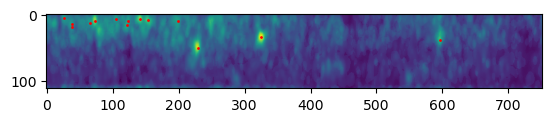

In [217]:
eg = egs[1]
features = build_candidates(
    eg.dense_precursors,
    eg.dense_fragments,
    eg.scan_limits.astype(np.int32),
    eg.frame_limits.astype(np.int32),
    eg.score_group_precursor_mz,
    eg.score_group_precursor_intensity,
    eg.score_group_fragment_mz,
    eg.score_group_fragment_intensity,
    eg,
    kernel,
    jit_data,
    15,
    weights = np.array([1,1,1,0.5,0.5,0.5]),
)

In [157]:
feature_vector = []
for f in features:
    feature_vector.append(f.features)

feature_vector = np.array(feature_vector)

In [220]:
eg.score_group_precursor_mz

array([431.19934, 431.53378, 431.86826, 431.87122, 432.20566, 432.54013],
      dtype=float32)

: 

In [101]:
jit_data.scan_max_index

928

In [71]:
eg.score_group_fragment_intensity

array([[0.15523933, 0.        , 0.        , 0.        , 0.20827942,
        1.        , 0.        , 0.17076325, 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.02181581, 0.02533355, 0.05842028, 0.        ,
        0.        , 1.        , 0.        , 0.03618305, 0.00168511,
        0.81347954, 0.38687974]], dtype=float32)

NameError: name 'peak_scan_list' is not defined

In [58]:
n_scores = eg.precursor_intensity.shape[0]

for score_idx in range(n_scores):

    fragment_mask = fragment_intensity[score_idx] > 0
    precursor_mask = precursor_intensity[score_idx] > 0


NameError: name 'fragment_intensity' is not defined

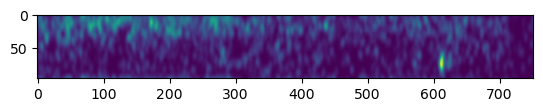

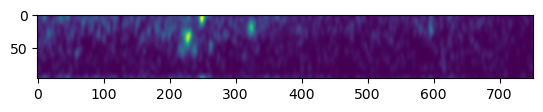

In [39]:
for i in range(s.shape[0]):
    plt.imshow(s[i])
    plt.show()

In [10]:
for eg in egs:

    if eg.dense_precursors.shape[-1] > 10:
        s = build_score(
            eg.dense_precursors, 
            eg.dense_fragments, 
            eg.precursor_mz,
            eg.precursor_intensity,
            eg.fragment_mz,
            eg.fragment_intensity,
            kernel
        )

In [11]:
egs[0].fragment_intensity
egs[0].decoy

array([1, 0], dtype=uint8)

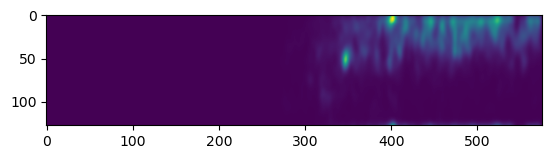

In [15]:
plt.imshow(s[0])

In [6]:
from alphadia.extraction.numba import numeric
from alphadia.extraction.numba import fragments
import numba as nb
from tqdm import tqdm

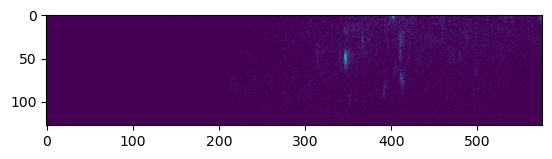

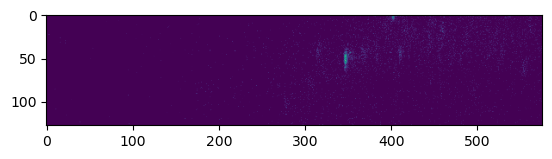

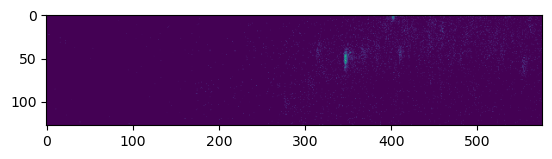

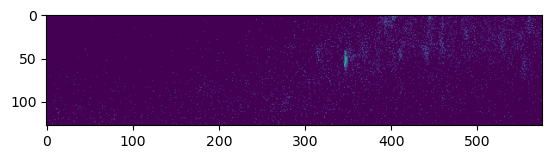

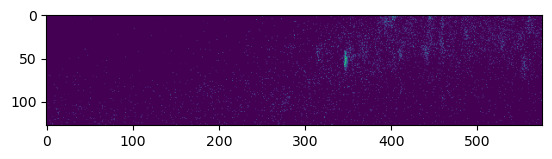

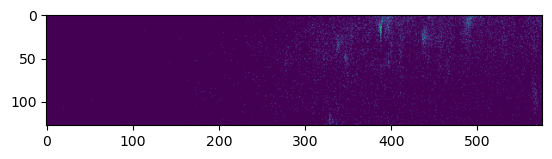

In [103]:
#%%timeit

tof_slice, values, push_indices, absolute_precursor_index, tof_indices = filter_push(
    precursor_tof_limits,
    jit_data.push_indices,
    jit_data.tof_indptr, 
    push_query,
    _absolute_precursor_index
)

precursor_index = np.unique(absolute_precursor_index)
n_precursor_indices = len(precursor_index)
precursor_index_reverse = np.zeros(np.max(precursor_index)+1, dtype=np.int64)
precursor_index_reverse[precursor_index] = np.arange(len(precursor_index))

relative_precursor_index = precursor_index_reverse[absolute_precursor_index]

frame_indices = push_indices // jit_data.scan_max_index
scan_indices = push_indices % jit_data.scan_max_index
precursor_cycle_indices = (frame_indices-jit_data.zeroth_frame)//jit_data.cycle.shape[1]

# cycle values
precursor_cycle_start = int(eg.frame_limits[0,0]-jit_data.zeroth_frame)//jit_data.cycle.shape[1]
precursor_cycle_stop = int(eg.frame_limits[0,1]-jit_data.zeroth_frame)//jit_data.cycle.shape[1]
precursor_cycle_len = precursor_cycle_stop - precursor_cycle_start

# scan valuesa
mobility_start = eg.scan_limits[0,0]
mobility_stop = eg.scan_limits[0,1]
mobility_len = mobility_stop - mobility_start

#tof_indices = jit_data.tof_indices[values]
mz_values = jit_data.mz_values[tof_indices]

intensities = jit_data.intensity_values_t[values]

# number of channels: intensity, mz
n_channels = 2

n_tof_slices = len(precursor_tof_limits)

dense_output = np.zeros(
    (
        n_channels, 
        n_tof_slices,
        n_precursor_indices,
        mobility_len,
        precursor_cycle_len
    ), 
    dtype=np.float64
)

# create dense intensities
for i, (_tof_slice, intensity, mz, p_slice) in enumerate(zip(tof_slice, intensities, mz_values, relative_precursor_index)):
    mobility = scan_indices[i]-mobility_start
    precursor_cycle = precursor_cycle_indices[i]-precursor_cycle_start
    dense_output[0, _tof_slice, p_slice ,mobility, precursor_cycle] += intensity

for i in range(n_tof_slices):
    plt.imshow(dense_output[0,i,0,:,:])
    plt.show()


In [18]:
values.shape

(4416,)

In [22]:
np.unique(absolute_precursor_index)

array([0])

In [20]:
push_indices.shape

(4416,)

In [21]:
tof_slice.shape

(4416,)

In [30]:
nb.typeof(jit_data.push_indices)

array(uint32, 1d, C)

In [32]:
push_query.shape

(84224,)

In [33]:
push_indices.shape

(4686,)

In [40]:
absolute_precursor_index.shape

(70656,)

In [51]:
push_indices, absolute_precursor_cycle = get_push_indices(
        jit_data,
        eg.frame_limits,
        eg.scan_limits,
        fragment_cycle_mask
    )

In [54]:
push_indices.shape

(8192,)

In [52]:
np.unique(absolute_precursor_cycle)

array([1])

In [44]:
np.unique(source_indices)

array([0, 1, 2])

In [45]:
np.unique(absolute_precursor_index)

array([0, 1])

In [46]:
quadrupole_mz

array([[403.70510864, 404.20678711],
       [394.70230103, 395.20397949]])

In [27]:
push_query.shape

(4096,)

In [ ]:
cycle_limits = eg.frame_limits//jit_data.cycle.shape[1]

In [ ]:
@nb.njit

def get_optimized_push_indices(
        jit_data,
        cycle_limits,
        scan_limits,
        score_group_cycle_mask,
        precursor_cycle_mask,
    ):

    for cycle_index in range(cycle_limits[0,0], cycle_limits[0,1]):
        cycle_start_index = cycle_index * jit_data.cycle.shape[1] * jit_data.scan_max_index

        
get_optimized_push_indices(
        jit_data,
        cycle_limits,
        eg.scan_limits,
        score_group_cycle_mask,
        precursor_cycle_mask,
    )

In [ ]:
cycle_limits

In [ ]:



             
push_indices, score_group, absolute_precursor_cycle = get_push_indices(
    jit_data,
    eg.frame_limits,
    eg.scan_limits,
    score_group_cycle_mask,
    precursor_cycle_mask,
)


In [ ]:
%timeit get_push_indices(jit_data, eg.frame_limits, eg.scan_limits, score_group_cycle_mask, precursor_cycle_mask)

In [ ]:
@nb.njit
def unique(a):
    return np.array(list(set(a)))

%timeit unique(absolute_precursor_cycle)

In [ ]:
precursor_mz

In [ ]:
print()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
pos = ax.imshow(fragments_dense[1,1,0,:,:],cmap='RdBu_r')
fig.colorbar(pos, ax=ax)
plt.show()

In [ ]:
%%timeit
get_dense_hybrid(
    jit_data, 
    eg.frame_limits,
    eg.scan_limits,
    precursor_mz,
    120,
    fragment_mz,
    120,
    quadrupole_mz
    )

In [ ]:
fragment_mz

In [ ]:
%timeit get_dense_hybrid( jit_data, eg.frame_limits, eg.scan_limits, precursor_mz, fragment_mz, quadrupole_mz)

In [ ]:
import numba as nb

os.environ['DEBUG'] = 'True'

from alphadia.extraction.hybridselection import HybridElutionGroup, HybridElutionGroupContainer

def assemble_elution_groups(
        precursors_flat,
        rt_column='rt_library',
        mobility_column='mobility_library',
        precursor_mz_column='mz_library'
        ):
    
    """
    Assemble elution groups from precursor library.

    Parameters
    ----------

    precursors_flat : pandas.DataFrame
        Precursor library.

    rt_column : str
        Column name of the retention time values.

    mobility_column : str
        Column name of the mobility values.

    precursor_mz_column : str
        Column name of the precursor m/z values.

    Returns
    -------
    HybridElutionGroupContainer
        Numba jitclass with list of elution groups.
    """
    
    if len(precursors_flat) == 0:
        return

    available_isotopes = utils.get_isotope_columns(precursors_flat.columns)
    available_isotope_columns = [f'i_{i}' for i in available_isotopes]

    precursors_sorted = precursors_flat.sort_values('elution_group_idx').copy()

    @nb.njit(debug=True)
    def assemble_njit(
        elution_group_idx,
        precursor_idx,
        channel,
        flat_frag_start_stop_idx,
        rt_values,
        mobility_values,
        charge,
        decoy,
        precursor_mz,
        isotope_intensity
    ):
        elution_group = elution_group_idx[0]
        elution_group_start = 0
        elution_group_stop = 0

        eg_list = []
        
        while elution_group_stop < len(elution_group_idx)-1:
            
            elution_group_stop += 1

            if elution_group_idx[elution_group_stop] != elution_group:
                    
                eg_list.append(HybridElutionGroup(    
                    elution_group,
                    precursor_idx[elution_group_start:elution_group_stop],
                    channel[elution_group_start:elution_group_stop],
                    flat_frag_start_stop_idx[elution_group_start:elution_group_stop],
                    rt_values[elution_group_start],
                    mobility_values[elution_group_start],
                    charge[elution_group_start],
                    decoy[elution_group_start:elution_group_stop],
                    precursor_mz[elution_group_start:elution_group_stop],
                    isotope_intensity[elution_group_start:elution_group_stop]
                ))

                elution_group_start = elution_group_stop
                elution_group = elution_group_idx[elution_group_start]
                
        egs = nb.typed.List(eg_list)
        return HybridElutionGroupContainer(egs)

    return assemble_njit(
        precursors_sorted['elution_group_idx'].values.astype(np.uint32),
        precursors_sorted['precursor_idx'].values.astype(np.uint32),
        precursors_sorted['channel'].values.astype(np.uint32),
        precursors_sorted[['flat_frag_start_idx','flat_frag_stop_idx']].values.copy().astype(np.uint32),
        precursors_sorted[rt_column].values.astype(np.float64),
        precursors_sorted[mobility_column].values.astype(np.float64),
        precursors_sorted['charge'].values.astype(np.uint8),
        precursors_sorted['decoy'].values.astype(np.uint8),
        precursors_sorted[precursor_mz_column].values.astype(np.float64),
        precursors_sorted[available_isotope_columns].values.copy().astype(np.float32),
    )
    

In [ ]:
assemble_elution_groups(precursors_flat)

In [ ]:
%timeit assemble_elution_groups(precursors_flat)

In [ ]:
from alphadia.extraction import candidateselection

gaussian = candidateselection.GaussianFilter(dia_data)
kernel = gaussian.get_kernel()

In [ ]:
plt.imshow(kernel)

In [ ]:
kernel[:,10:].shape

In [ ]:
p = dense_precursors[0,0,:,:32,:64]
p.shape

In [ ]:
x = np.tile(p, (10,1,1,1))

In [ ]:
x.shape

In [ ]:
%timeit smooth = fourier_a1(x, kernel)

In [ ]:
plt.imshow(p[0])

In [ ]:
plt.imshow(smooth[0])

In [ ]:
plt.imshow(roll(smooth[0,0],-10,-10))

In [ ]:
import numba as nb
import numpy as np

@nb.njit
def jit_fft(x):
    return np.fft.fft(x)

a = np.array([2, 7, 1, 8, 2, 8, 1, 8])
jit_fft(a)

In [ ]:
from alphadia.extraction import quadrupole, scoring, features
q = quadrupole.SimpleQuadrupole(dia_data.cycle)

In [ ]:
from alphadia.extraction import scoring

extraction = scoring.MS2ExtractionWorkflow(
    dia_data,
    precursors_flat,
    fragments_flat,
    candidates,
    q,
    precursor_mz_tolerance=30,
    fragment_mz_tolerance=30
)

feature_df, fragment_df = extraction()

In [ ]:
df = scoring.fdr_correction(feature_df)

In [ ]:
df = scoring.fdr_correction(df)